# **Import TensorFlow and other libraries**

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# **Download and explore the dataset**

Sử dụng tập dữ liệu khoảng 3.700 bức ảnh về hoa. Tập dữ liệu chứa 5 thư mục con, mỗi thư mục con một lớp:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar = True)
data_dir = pathlib.Path(data_dir) 

228818944/228813984 [==============================] - 7s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Xem một số mẫu dữ liệu

Hoa hồng 

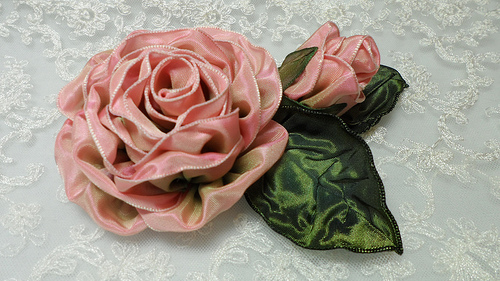

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

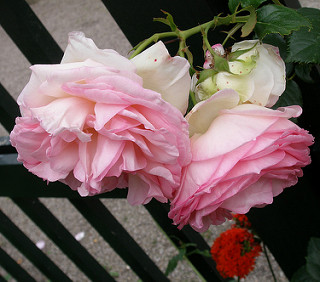

In [ ]:
PIL.Image.open(str(roses[1]))

Hoa Tulip

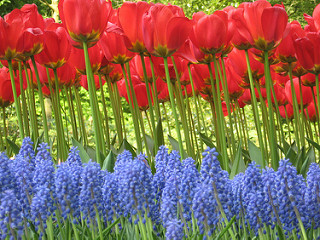

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


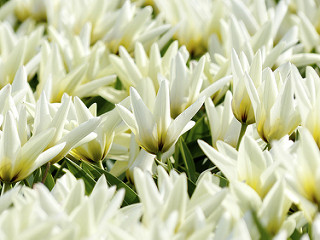

In [ ]:
PIL.Image.open(str(tulips[10]))


# **Load using keras.preprocessing**

Sử dụng `tf.keras.preprocessing.image_dataset_from_directory` để tải hình ảnh. Điều này sẽ đưa dữ liệu từ một thư mục hình ảnh trên đĩa sang `tf.data.Dataset` chỉ trong một vài dòng mã

## Create a dataset

Xác định một số tham số cho bộ nạp:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Sử dụng 80% hình ảnh để đào tạo và 20% để xác thực

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

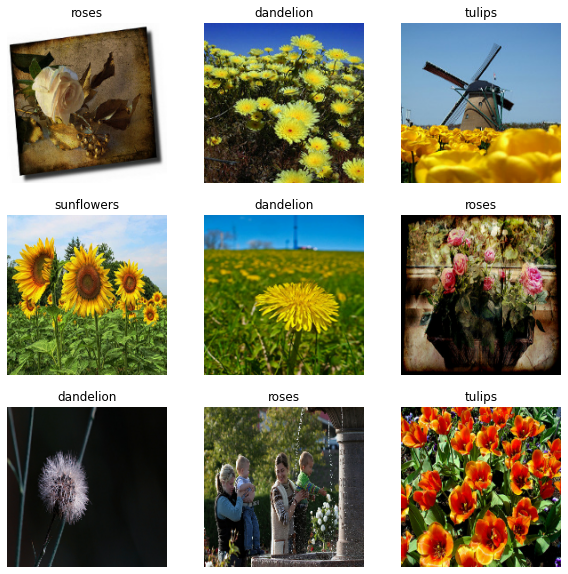

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

Hãy đảm bảo sử dụng tìm nạp trước có bộ đệm để có thể mang lại dữ liệu từ đĩa mà không bị chặn I / O. Đây là hai phương pháp quan trọng nên sử dụng khi tải dữ liệu.

>- `Dataset.cache()`: giữ hình ảnh trong bộ nhớ sau khi chúng được tải ra khỏi đĩa trong epoch đầu tiên. Điều này sẽ đảm bảo tập dữ liệu không trở thành nút cổ chai trong khi đào tạo mô hình. Nếu tập dữ liệu quá lớn để vừa với bộ nhớ,cũng có thể sử dụng phương pháp này để tạo bộ đệm ẩn trên đĩa hoạt động hiệu quả.
>- `Dataset.prefetch()`: chồng chéo tiền xử lý dữ liệu và thực thi mô hình trong khi đào tạo.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Các giá trị kênh RGB nằm trong phạm vi `[0, 255]`. Điều này không lý tưởng cho một mạng nơ-ron, chúng ta nên chuẩn hóa dữ liệu về các giá trị nằm trong phạm vi `[0, 1]` bằng cách sử dụng `Rescaling layer`

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Có hai cách để sử dụng lớp này. Có thể áp dụng nó vào tập dữ liệu bằng cách gọi `map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Hoặc, Có thể thêm vào lớp bên trong định nghĩa mô hình của mình, điều này có thể đơn giản hóa việc triển khai. 

# **Create the model**

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

## Compile the model



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

Xem tất cả các lớp của mạng bằng phương pháp tóm tắt của mô hình: `summary`

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model - Fit the model

In [ ]:
history = model.fit(
  train_ds, epochs = 10,
  validation_data = val_ds,
)

Epoch 1/10
92/92 [==============================] - 35s 59ms/step - loss: 1.3626 - accuracy: 0.4074 - val_loss: 1.0792 - val_accuracy: 0.5886
Epoch 2/10
92/92 [==============================] - 4s 41ms/step - loss: 0.9883 - accuracy: 0.6141 - val_loss: 0.9700 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 4s 41ms/step - loss: 0.8102 - accuracy: 0.6901 - val_loss: 0.9903 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 4s 40ms/step - loss: 0.6021 - accuracy: 0.7752 - val_loss: 0.9800 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 4s 41ms/step - loss: 0.4003 - accuracy: 0.8600 - val_loss: 1.0249 - val_accuracy: 0.6512
Epoch 6/10
92/92 [==============================] - 4s 41ms/step - loss: 0.2253 - accuracy: 0.9264 - val_loss: 1.3015 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 4s 41ms/step - loss: 0.1269 - accuracy: 0.9639 - val_loss: 1.5173 - val_accuracy: 0.6485
Epoch 8/10
9

## Visualize training results

Tạo các biểu đồ mất mát và độ chính xác trên các tập huấn luyện và xác nhận.

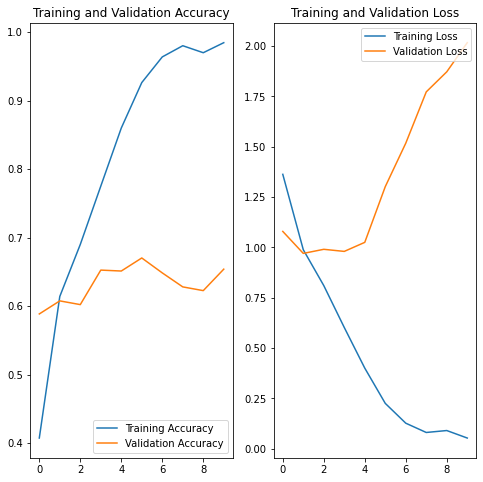

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Từ biểu đồ ta thấy độ chính xác của quá trình huấn luyện và độ chính xác của việc xác thực bị sai lệch với biên độ lớn và mô hình chỉ đạt được độ chính xác khoảng 60% trên bộ xác thực.



## Overfitting

Trong các biểu đồ ở trên, độ chính xác của quá trình huấn luyện đang tăng tuyến tính theo thời gian, trong khi độ chính xác của việc xác nhận sẽ giảm khoảng 60% trong quá trình luyện.Ngoài ra, sự khác biệt về độ chính xác giữa đào tạo và độ chính xác xác thực là đáng chú ý — một dấu hiệu của `overfitting`

Khi có một số lượng nhỏ các maux đào tạo, mô hình đôi khi học hỏi từ các nhiễu hoặc các chi tiết không mong muốn từ các mãu đào tạo — đến mức nó tác động tiêu cực đến hiệu suất của mô hình đối với các mẫu mới. Hiện tượng này được gọi là `overfitting`. Có nghĩa là mô hình sẽ gặp khó khăn khi tổng quát hóa trên một tập dữ liệu mới.

Có nhiều cách để chống lại `overfitting` trong quá trình đào tạo. Trong sổ tay này,chúng ta sẽ sử dụng `data augmentation`  và thêm `Dropout` vào mô hình của mình.

## Data Augmentation

Tăng cường dữ liệu sử dụng phương pháp tạo dữ liệu đào tạo bổ sung từ các ví dụ hiện có của bạn bằng cách tăng cường chúng bằng cách sử dụng các phép biến đổi ngẫu nhiên mang lại hình ảnh trông đáng tin cậy. Điều này giúp mô hình hiển thị nhiều khía cạnh của dữ liệu hơn và khái quát hóa tốt hơn.



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

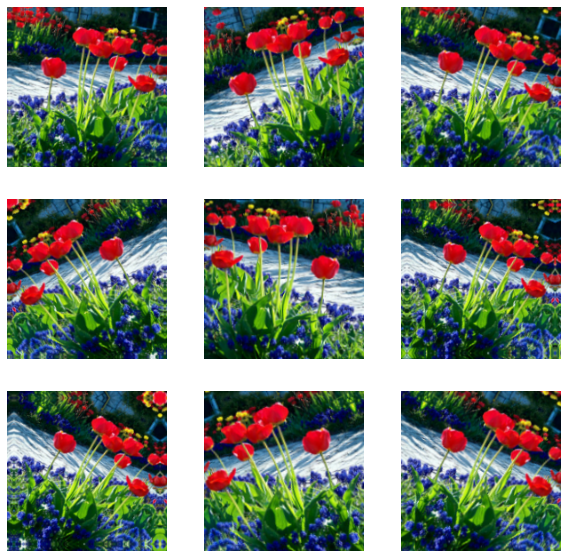

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Một kỹ thuật khác để giảm tình trạng overfitting là thêm  `Dropout` vào mạng, một hình thức chính quy hóa.

Khi áp dụng `Dropout` cho một lớp, nó ngẫu nhiên rơi ra (bằng cách đặt kích hoạt thành 0) một số đơn vị đầu ra từ lớp trong quá trình đào tạo.`Dropout` lấy một số phân số làm giá trị đầu vào của nó, ở dạng chẳng hạn như 0,1, 0,2, 0,4. Điều này có nghĩa là bỏ 10%, 20% hoặc 40% đơn vị đầu ra ngẫu nhiên khỏi lớp được áp dụng.



In [ ]:
model_2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 49ms/step - loss: 1.3216 - accuracy: 0.4210 - val_loss: 1.0872 - val_accuracy: 0.5572
Epoch 2/15
92/92 [==============================] - 4s 46ms/step - loss: 1.0478 - accuracy: 0.5889 - val_loss: 1.0250 - val_accuracy: 0.5708
Epoch 3/15
92/92 [==============================] - 4s 47ms/step - loss: 0.9569 - accuracy: 0.6230 - val_loss: 0.9315 - val_accuracy: 0.6144
Epoch 4/15
92/92 [==============================] - 4s 47ms/step - loss: 0.8778 - accuracy: 0.6580 - val_loss: 0.9193 - val_accuracy: 0.6308
Epoch 5/15
92/92 [==============================] - 4s 46ms/step - loss: 0.8199 - accuracy: 0.6856 - val_loss: 0.8996 - val_accuracy: 0.6390
Epoch 6/15
92/92 [==============================] - 4s 47ms/step - loss: 0.7741 - accuracy: 0.6999 - val_loss: 0.7917 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 4s 46ms/step - loss: 0.7171 - accuracy: 0.7217 - val_loss: 0.7969 - val_accuracy: 0.6894
Epoch 8/15
92

## Visualize training results

Sau khi `data augmentation` và `Dropout`, ít overfitting hơn trước, đồng thời độ chính xác của quá trình đào tạo và xác thực được liên kết chặt chẽ hơn.

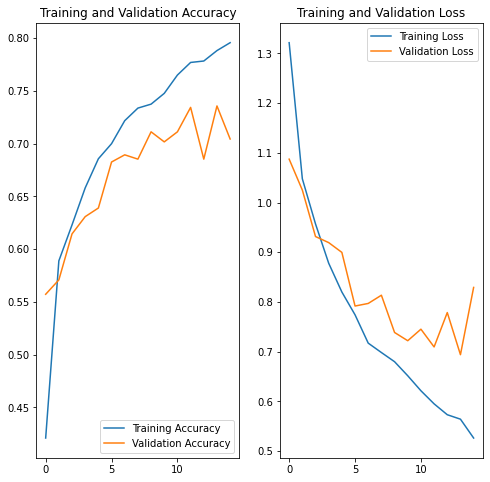

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nhìn vào đồ thị ta có thể thấy sau khi tăng cường dữ liệu và `Dropout` mô hình của chúng ta đã chạy tốt hơn khá nhiều với gần 80% cho tập huấn luyện và gần 75% cho tập thử nghiệm. Đường cong hàm mất mát của cả tập huấn luyện và tập thử nghiệm cũng có xu hướng đi xuống.

## Predict on new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.46 percent confidence.


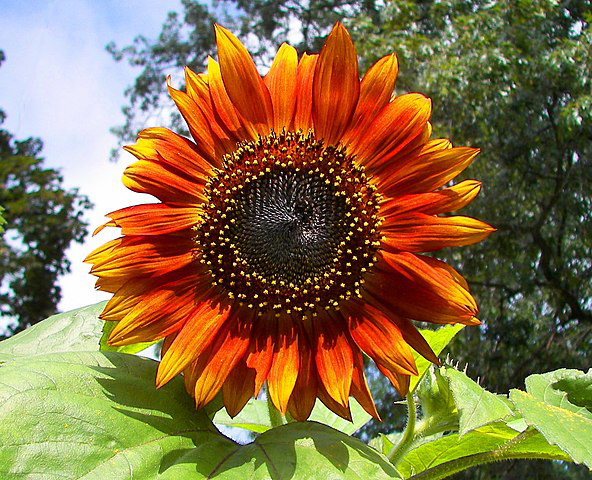

In [ ]:
PIL.Image.open(str(sunflower_path))